In [1]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

Here I'm performing a power analysis to work out how many participants we should run for the zipping pre-post study.

I'm assuming that I'll run with 72 trials in either phase.

And I'm looking for an effect of phase on rt/ accuracy/ d'.

We assume that responses for compatible and incompatible trials are drawn from separate distributions with equal variance.

d' tells us the separation between these distributions in standardized units, so we don't need to assume particular values for the means.


In [15]:
df_zip_example = pd.read_csv('df_zip_example.csv')
df_zip_example = df_zip_example[~df_zip_example.practice]

In [16]:
example_ppt = df_zip_example.gameID.unique()[0]

In [17]:
df_example_ppt = df_zip_example[df_zip_example.gameID == example_ppt]

In [20]:
df_example_ppt

,Unnamed: 0,index,_id,rt,stimulus,response,response_correct,stimURL,chunk_id,rep,...,stimVersionInd,trial_num,key_presses,mask,studyLocation,response_key_dict,composite_talls_name,block,phase,flagRT
4,4,1643,62859ad55422ef0b785a48f0,1832.0,https://tower-4-block-unique-silhouettes-compo...,z,0,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_102_122,pre_0,pre_zipping_trials,False
5,5,1644,62859ada5422ef0b785a48f1,1127.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_101_114,pre_0,pre_zipping_trials,False
6,6,1645,62859adf5422ef0b785a48f2,1091.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_101_114,pre_0,pre_zipping_trials,False
7,7,1646,62859ae55422ef0b785a48f3,1161.0,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_102_122,pre_0,pre_zipping_trials,False
8,8,1647,62859aea5422ef0b785a48f4,1014.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_111_127,pre_0,pre_zipping_trials,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,1934,6285a0225422ef0b785a4b7e,993.0,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_101_114,post_1,post_zipping_trials,False
220,220,1935,6285a0275422ef0b785a4b85,855.0,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_102_122,post_1,post_zipping_trials,False
221,221,1936,6285a02d5422ef0b785a4b8d,1434.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_102_122,post_1,post_zipping_trials,False
223,223,1938,6285a0325422ef0b785a4b95,686.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,NaN,NaN,...,2.0,NaN,0.0,https://zipping-masks-16x16-small-png.s3.amazo...,SONA,"{'valid': 'm', 'invalid': 'z'}",talls_111_127,post_1,post_zipping_trials,False


I'm trying to work out how many participants we need for the zipping study. Here I am outlining my current approach, which is missing some crucial details. If you can see what I'm doing wrong, or have some time to talk about it, that would be very helpful.

I'm attempting to run a power analysis, by which I mean I'm trying to work out how changing the number of participants will change the statistical power of our experiment. Following the approach Haoliang took, I'm trying to do this under different settings of d' (same as "Cohen's d" in this context?) which, as I understand it, allows us to consider a range of separabilities for RT (or accuracy), while not having to commit to any specific mean values of RT for either condition.

The approach I want to take is the following:

For many iterations:
    Simulate data for a number of participants (here I get stuck- how do I simulate data if I don't have means?).
    Run the nested model comparison (series of lmers), seeing whether a model containing an interaction between compatible and phase is better than one without: extract a p-value.

Find the proportion of p-values that are <=0.05. This proportion is the power.

Run the above for a range of n, then plot n against power, for each value of d'.


My intuition tells me that d' factors into the simulation of the data somehow, but I can't see how.


In [ ]:
# simulate the data I want

phases = ['pre_zipping_trials', 'post_zipping_trials']

compatibility = ['compatible', 'incompatible', 'novel']

composite_id = ['A', 'B', 'C']

In [167]:
# params
alpha = 0.05

n_trials_per_condition = 24

n_iter = 500
ns = list(range(0,180,12))
d_primes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0] # which d primes are these?

In [168]:
mu_compatible = 1000
mu_incompatible = 1200
mu_diff = mu_incompatible - mu_compatible


df_power = pd.DataFrame()

for n_ppts in ns:
    
    for d in d_primes:
        
        sigma = mu_diff/d

        compatible_values = {}
        incompatible_values = {}
        p_values = {}
        significant = {}

        # do n_iter times:
        for n in range(0, n_iter):
            
            # simulate data
            compatible_values[n] = np.random.normal(mu_compatible, sigma, n_ppts * n_trials_per_condition) #WRONG
            incompatible_values[n] = np.random.normal(mu_incompatible, sigma, n_ppts * n_trials_per_condition)
            
            # calculate statistic
            p_values[n] = stats.ttest_ind(compatible_values[n], incompatible_values[n])
            
            # mark significant statistics?
            significant[n] = p_values[n].pvalue < alpha
            
            # calculate power
            power = sum(np.array(list(significant.values())))/ len(significant)
            

        df_power = df_power.append(
            {
                'n_ppts': n_ppts,
                'power': power,
                'd': d,
            }, ignore_index=True)

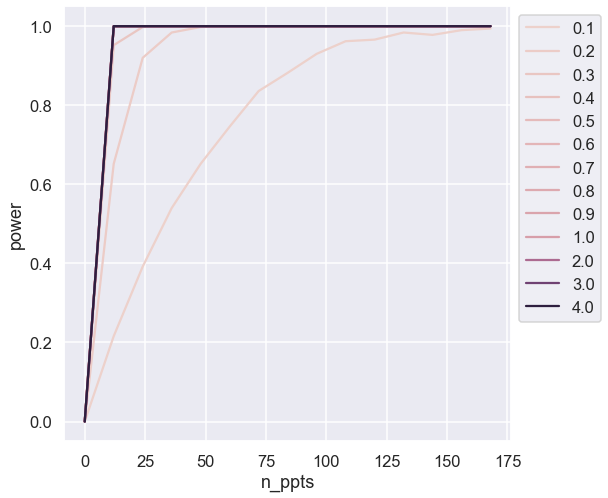

In [169]:
plt.figure(figsize = (8,8))

sns.lineplot(
    data = df_power,
    x = 'n_ppts',
    y = 'power',
    hue = 'd'
)

plt.legend(d_primes, bbox_to_anchor=(1,1))

In [ ]:
# backup

mu_compatible = 1000
mu_incompatible = 1200
mu_diff = mu_incompatible - mu_compatible


df_power = pd.DataFrame()

for n_ppts in ns:
    
    for d in d_primes:
        
        sigma = mu_diff/d

        compatible_values = {}
        incompatible_values = {}
        p_values = {}
        significant = {}

        # do n_iter times:
        for n in range(0, n_iter):
            
            # simulate data
            compatible_values[n] = np.random.normal(mu_compatible, sigma, n_ppts * n_trials_per_condition) #WRONG
            incompatible_values[n] = np.random.normal(mu_incompatible, sigma, n_ppts * n_trials_per_condition)
            
            # calculate statistic
            p_values[n] = stats.ttest_ind(compatible_values[n], incompatible_values[n])
            
            # mark significant statistics?
            significant[n] = p_values[n].pvalue < alpha
            
            # calculate power
            power = sum(np.array(list(significant.values())))/ len(significant)
            

        df_power = df_power.append(
            {
                'n_ppts': n_ppts,
                'power': power,
                'd': d,
            }, ignore_index=True)